<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/experimental/hmm_market_behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [52]:
start_date_string = '2018-04-01'
end_date='2023-01-10'

In [53]:
!pip install hmmlearn

In [54]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from matplotlib import cm, pyplot as plt
from hmmlearn.hmm import GaussianHMM
import scipy
import datetime
import json
import seaborn as sns
#from sklearn.externals import joblib
import yfinance as yf
sns.set()

### Basic functions for the analysis
Modelling, feature engineering, plotting.

In [55]:
import warnings
warnings.filterwarnings("ignore")

# Brute force modelling
def get_best_hmm_model(X, max_states, max_iter = 10000):
    best_score = -(10 ** 10)
    best_state = 0

    for state in range(1, max_states + 1):
        hmm_model = GaussianHMM(n_components = state, random_state = 100,
                                covariance_type = "diag", n_iter = max_iter).fit(X)
        if hmm_model.score(X) > best_score:
            best_score = hmm_model.score(X)
            best_state = state

    best_model = GaussianHMM(n_components = 2, random_state = 100,
                                covariance_type = "diag", n_iter = max_iter).fit(X)
    return best_model

# Normalized st. deviation
def std_normalized(vals):
    return np.std(vals) / np.mean(vals)

# Ratio of diff between last price and mean value to last price
def ma_ratio(vals):
    return (vals[-1] - np.mean(vals)) / vals[-1]

# z-score for volumes and price
def values_deviation(vals):
    return (vals[-1] - np.mean(vals)) / np.std(vals)

# General plots of hidden states
def plot_hidden_states(hmm_model, data, X, column_price):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(hmm_model.n_components, 3, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))
    hidden_states = hmm_model.predict(X)

    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax[0].plot(data.index, data[column_price], c = 'grey')
        ax[0].plot(data.index[mask], data[column_price][mask], '.', c = colour)
        ax[0].set_title("{0}th hidden state".format(i))
        ax[0].grid(True)

        ax[1].hist(data["future_return"][mask], bins = 30)
        ax[1].set_xlim([-0.1, 0.1])
        ax[1].set_title("future return distrbution at {0}th hidden state".format(i))
        ax[1].grid(True)

        ax[2].plot(data["future_return"][mask].cumsum(), c = colour)
        ax[2].set_title("cummulative future return at {0}th hidden state".format(i))
        ax[2].grid(True)

    plt.tight_layout()
def print_results(hmm_model,test_dataset):
    hidden_states = hmm_model.predict(test_dataset)
    print(hidden_states)
    return 0
def mean_confidence_interval(vals, confidence):
    a = 1.0 * np.array(vals)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m - h, m, m + h

def compare_hidden_states(hmm_model, cols_features, conf_interval, iters = 1000):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(len(cols_features), hmm_model.n_components, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))

    for i in range(0, hmm_model.n_components):
        mc_df = pd.DataFrame()

        # Samples generation
        for j in range(0, iters):
            row = np.transpose(hmm_model._generate_sample_from_state(i))
            mc_df = mc_df.append(pd.DataFrame(row).T)
        mc_df.columns = cols_features

        for k in range(0, len(mc_df.columns)):
            axs[k][i].hist(mc_df[cols_features[k]], color = colours[i])
            axs[k][i].set_title(cols_features[k] + " (state " + str(i) + "): " + str(np.round(mean_confidence_interval(mc_df[cols_features[k]], conf_interval), 3)))
            axs[k][i].grid(True)

    plt.tight_layout()

### Downloading data and plot

[*********************100%%**********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


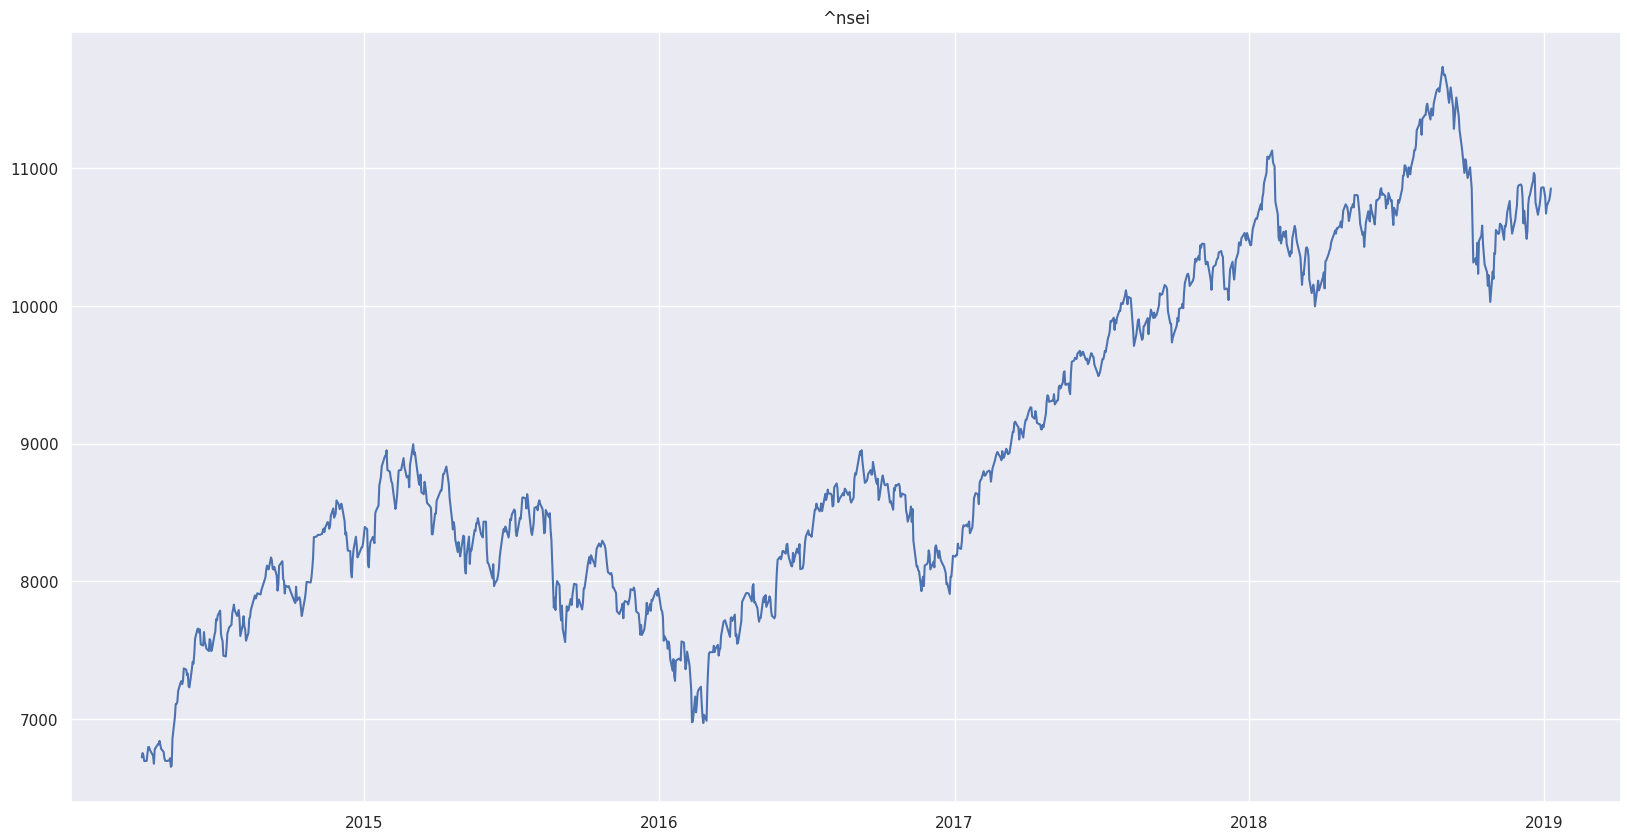

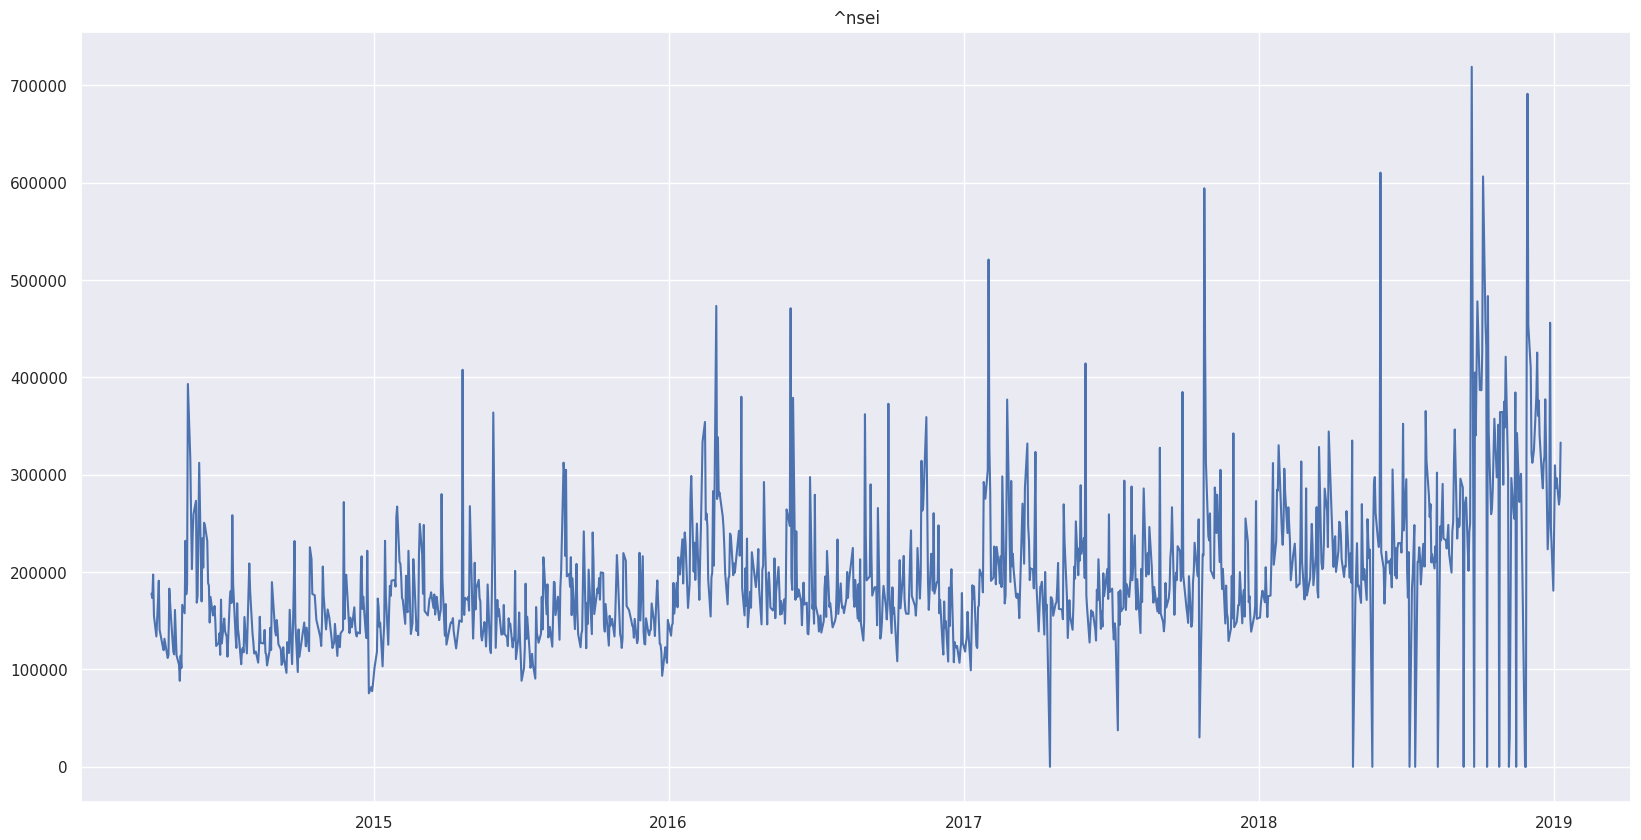

In [56]:
start_date_string = '2014-04-01'
end_date='2019-01-10'
asset = '^nsei'
column_price = 'Adj Close'
column_high = 'High'
column_low = 'Low'
column_volume = 'Volume'

#quandl.ApiConfig.api_key = YOUR_QUANDL_API
dataset = yf.download('^nsei',start=start_date_string,end=end_date)

print(dataset.columns)

plt.figure(figsize=(20,10))
plt.plot(dataset['Adj Close'])
plt.title(asset)
plt.show()

plt.figure(figsize=(20,10))
plt.plot(dataset['Volume'])
plt.title(asset)
plt.show()

### Let's generate the features and look at them

<Figure size 2000x1000 with 0 Axes>

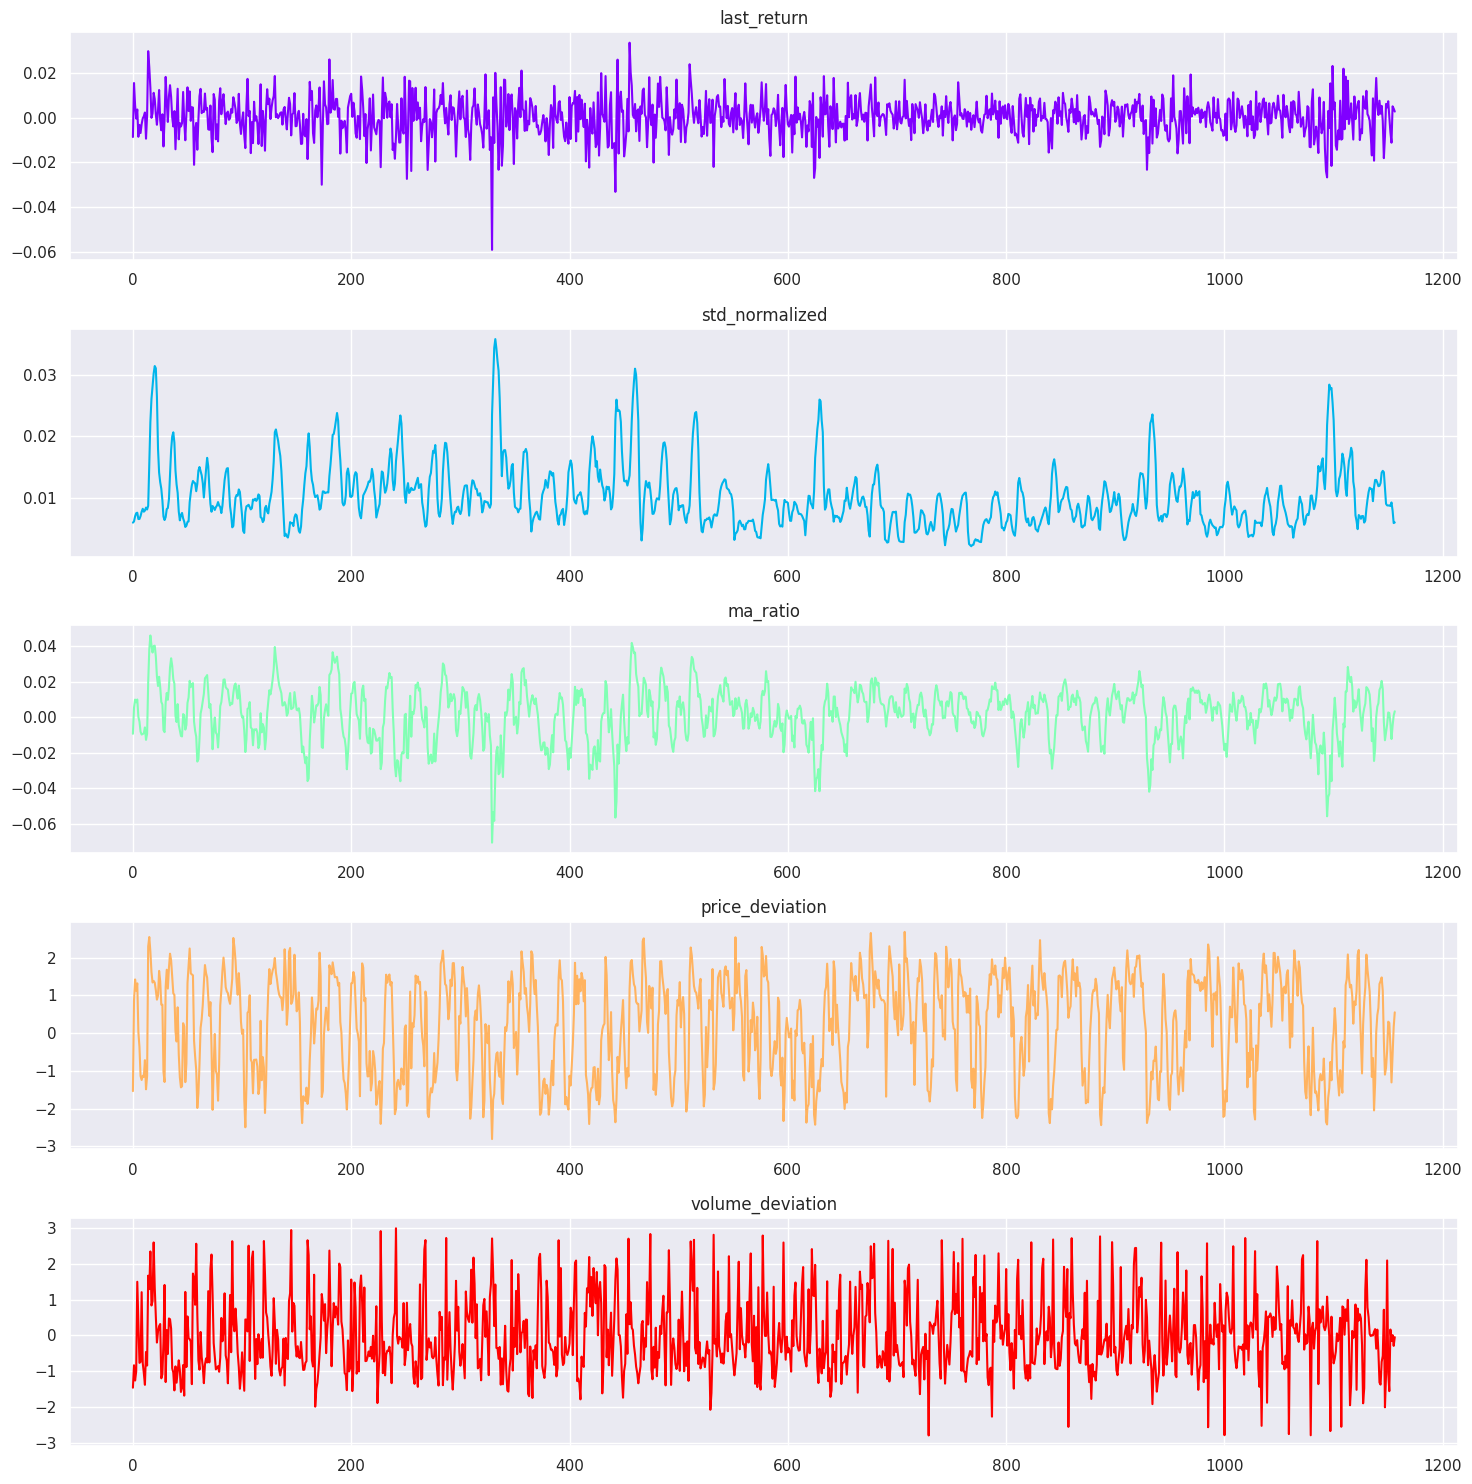

In [57]:
# Feature params
future_period = 1
std_period = 10
ma_period = 10
price_deviation_period = 10
volume_deviation_period = 10

# Create features
cols_features = ['last_return', 'std_normalized', 'ma_ratio', 'price_deviation', 'volume_deviation']
dataset['last_return'] = dataset[column_price].pct_change()
dataset['std_normalized'] = dataset[column_price].rolling(std_period).apply(std_normalized)
dataset['ma_ratio'] = dataset[column_price].rolling(ma_period).apply(ma_ratio)
dataset['price_deviation'] = dataset[column_price].rolling(price_deviation_period).apply(values_deviation)
dataset['volume_deviation'] = dataset[column_volume].rolling(volume_deviation_period).apply(values_deviation)

dataset["future_return"] = dataset[column_price].pct_change(future_period).shift(-future_period)

dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()

# Split the data on sets
train_ind = int(np.where(dataset.index =='2018-01-05')[0])
train_set = dataset[cols_features].values[:train_ind]
test_set = dataset[cols_features].values[train_ind:]

# Plot features
plt.figure(figsize=(20,10))
fig, axs = plt.subplots(len(cols_features), 1, figsize = (15, 15))
colours = cm.rainbow(np.linspace(0, 1, len(cols_features)))
for i in range(0, len(cols_features)):
    axs[i].plot(dataset.reset_index()[cols_features[i]], color = colours[i])
    axs[i].set_title(cols_features[i])
    axs[i].grid(True)

plt.tight_layout()

In [58]:
dataset.head(2)

,Open,High,Low,Close,Adj Close,Volume,last_return,std_normalized,ma_ratio,price_deviation,volume_deviation,future_return
Date,,,,,,,,,,,,
2014-04-16,6727.250000,6748.649902,6665.149902,6675.299805,6675.299805,119800,-0.008584,0.006024,-0.009339,-1.536042,-1.454267,0.015595
2014-04-17,6695.450195,6783.049805,6684.399902,6779.399902,6779.399902,131500,0.015595,0.006221,0.005299,0.856338,-0.829271,0.005642


### Modeling

In [59]:
model = get_best_hmm_model(X = train_set, max_states = 3, max_iter = 1000000)
print("Best model with {0} states ".format(str(model.n_components)))

Best model with 2 states 


### Lets look at state and the next market movement

<Figure size 1500x1500 with 0 Axes>

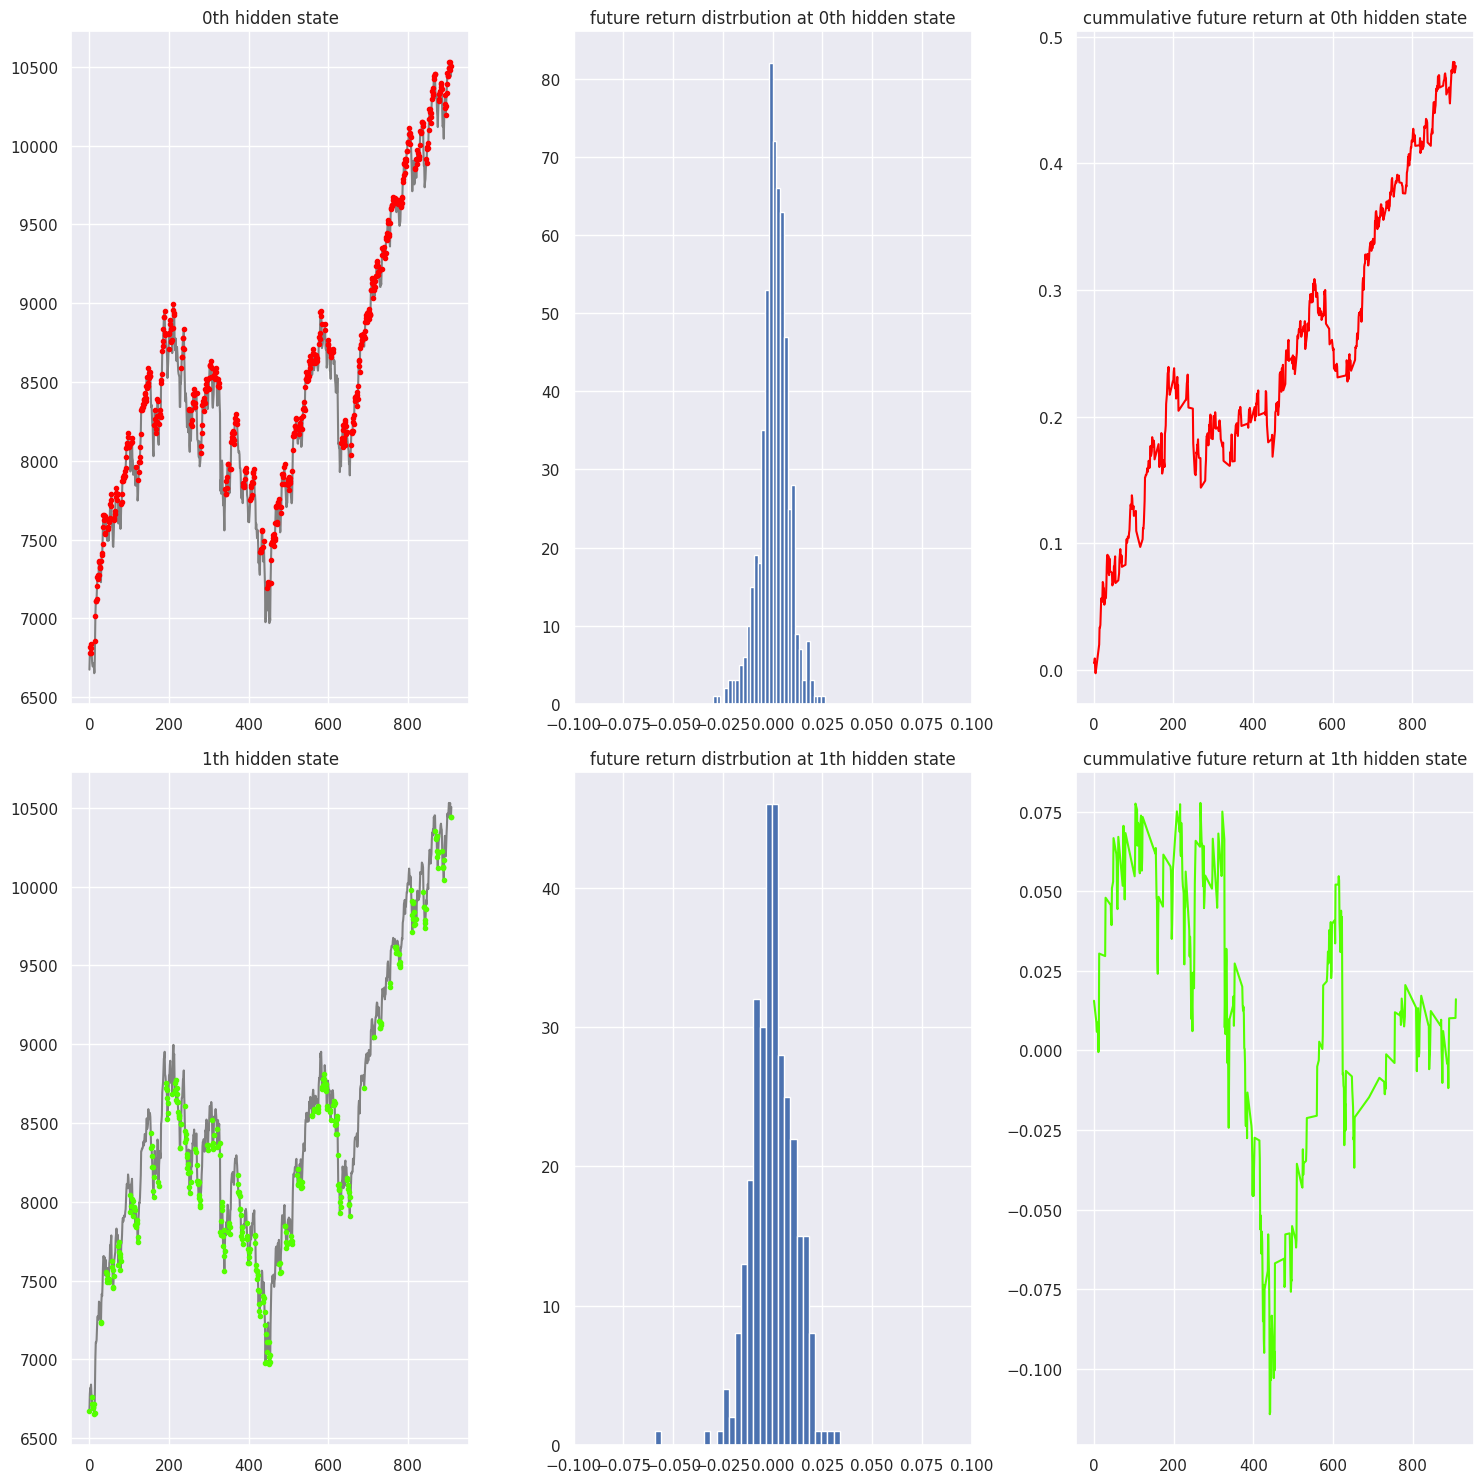

In [60]:
plot_hidden_states(model, dataset[:train_ind].reset_index(), train_set, column_price);

### Feature distribution depending on market state

In [61]:
#compare_hidden_states(hmm_model=model, cols_features=cols_features, conf_interval=0.95)

**bold text**### Save our model

In [62]:
#joblib.dump(model, 'quandl_' + asset.replace('/', '_') + '_final_model.pkl')

# Make Predictions

In [63]:
data_predict = yf.download('^nsei',start='2023-02-02')

[*********************100%%**********************]  1 of 1 completed


In [64]:
# Feature params
future_period = 1
std_period = 10
ma_period = 10
price_deviation_period = 10
volume_deviation_period = 10

# Create features
cols_features = ['last_return', 'std_normalized', 'ma_ratio', 'price_deviation', 'volume_deviation']
data_predict['last_return'] = data_predict[column_price].pct_change()
data_predict['std_normalized'] = data_predict[column_price].rolling(std_period).apply(std_normalized)
data_predict['ma_ratio'] = data_predict[column_price].rolling(ma_period).apply(ma_ratio)
data_predict['price_deviation'] = data_predict[column_price].rolling(price_deviation_period).apply(values_deviation)
data_predict['volume_deviation'] = data_predict[column_volume].rolling(volume_deviation_period).apply(values_deviation)

data_predict["future_return"] = data_predict[column_price].pct_change(future_period).shift(-future_period)

data_predict = data_predict.replace([np.inf, -np.inf], np.nan)
data_predict = data_predict.dropna()
test_set=data_predict[cols_features]

In [65]:
test_set.shape

(235, 5)

In [66]:
data_predict.shape

(235, 12)

<Figure size 1500x1500 with 0 Axes>

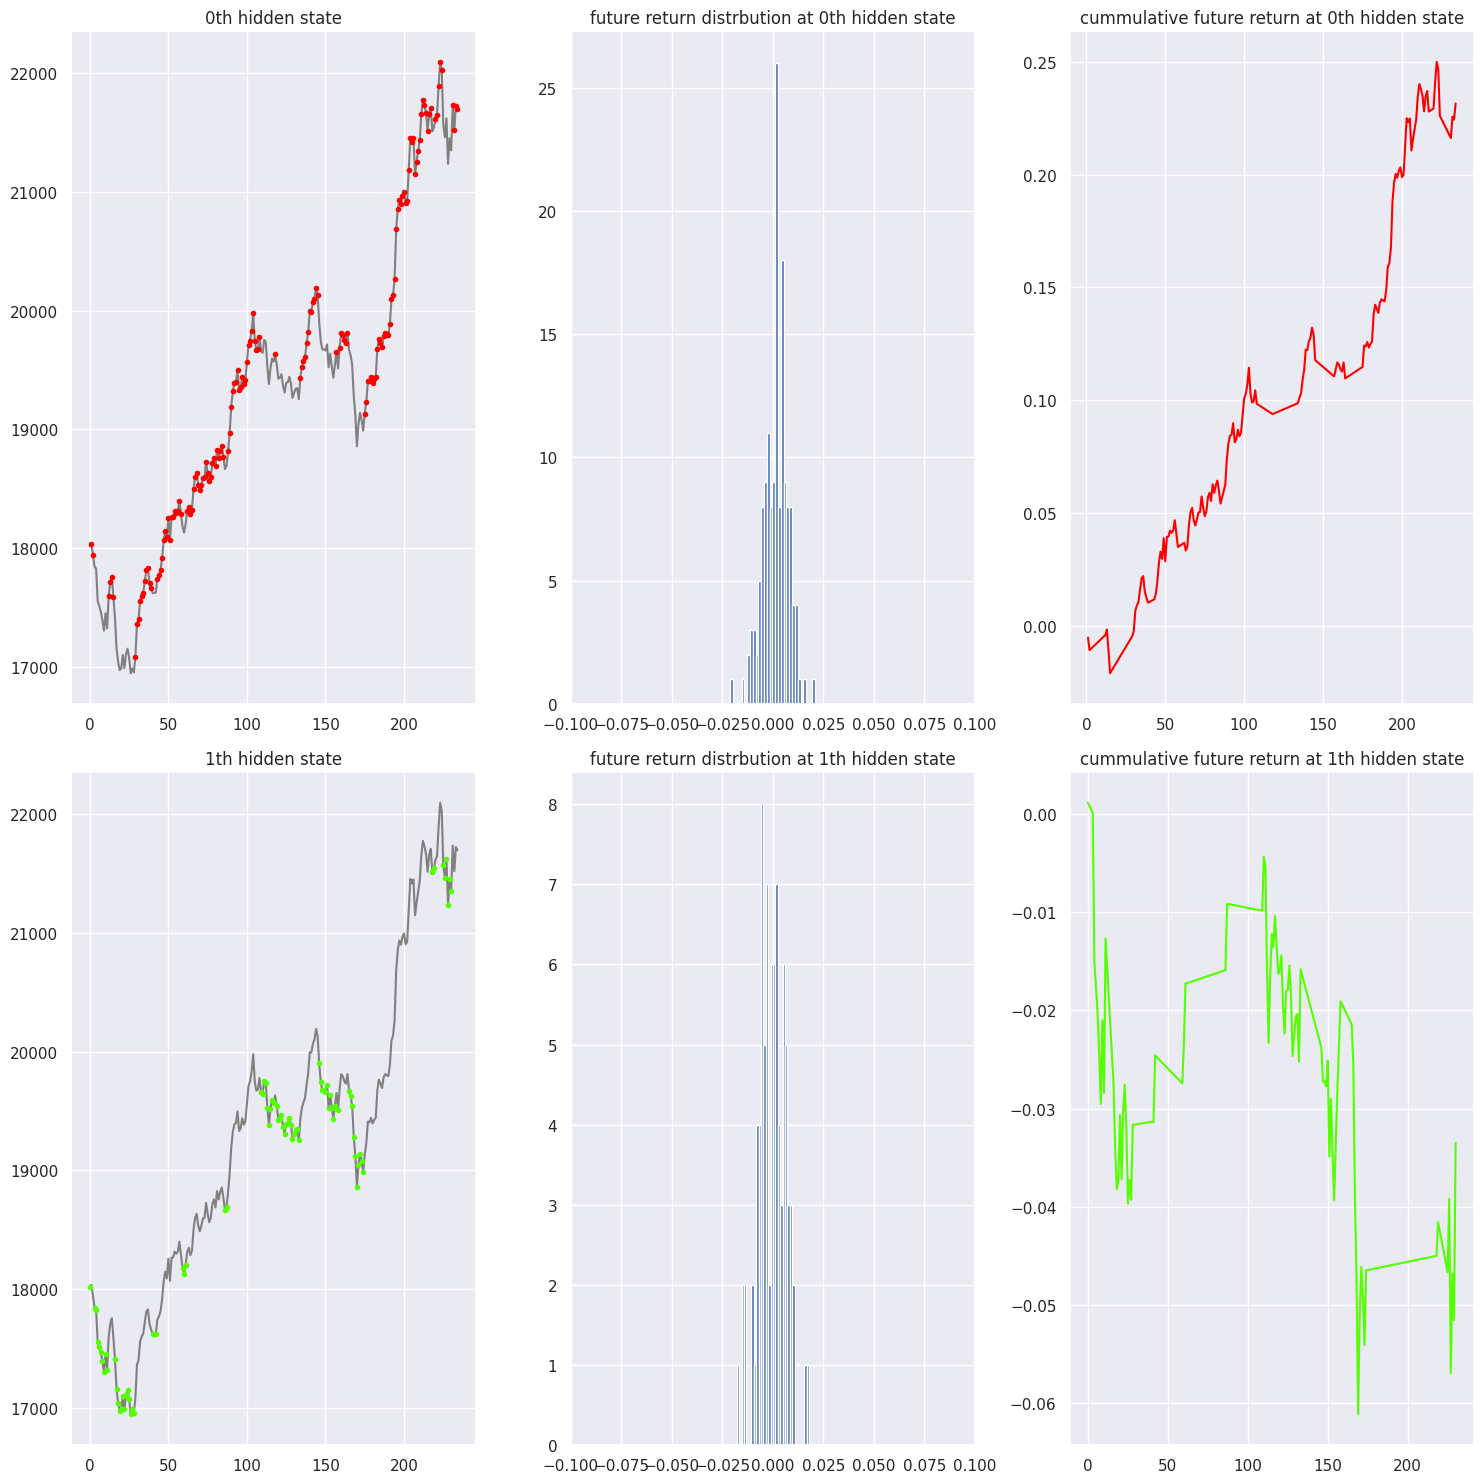

In [67]:
plot_hidden_states(model, data_predict.reset_index(), test_set, column_price);

In [68]:
print_results(model,test_set)

[1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 1 1 1 1 1 1 0 0 0 0]


0